In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [2]:
data = pd.read_csv('data/rating_complete.csv')
print(len(data))
data.head(2)

57633278


,user_id,anime_id,rating
0,0,430,9
1,0,1004,5


In [3]:
anime = pd.read_csv('data/anime.csv')
anime = anime.rename(columns={"MAL_ID": "anime_id"})
anime.head(2)

,anime_id,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [4]:
data_train = data
my_animelist = pd.read_csv('400000.csv')

In [5]:
# genres = []

# for i in range(len(anime)):
#     genres.extend(anime.iloc[i]['Genres'].split(', '))

# colms = list(set(genres))

# df_genres = pd.DataFrame(columns=colms)
# df_genres['anime_id'] = anime['anime_id']
# df_genres = df_genres.fillna(0)
# df_genres.index = df_genres['anime_id']
# df_genres.drop('anime_id', axis=1, inplace=True)

# for i in range(len(anime)):
#     list_genres = anime.iloc[i]['Genres'].split(', ')
#     for j in list_genres:
#         df_genres.at[i, j] = 1

# sum_col = [sum(df_genres[i]) for i in df_genres.columns]

# for i in df_genres.columns:
#     if sum(df_genres[i]) < np.percentile(np.array(sum_col), 10):
#         try:
#             df_genres.drop(i, axis=1, inplace=True)
#         except KeyError:
#             pass

# df_genres.head(3)

limit by years

In [6]:
max_year = 2222
min_year = 2000

anime_id = []
year = []

for i in anime['anime_id']:
    anime_id.append(i)
    try:
        year.append(int(re.findall('[0-9]{4}', str(anime.loc[anime['anime_id'] == i]['Aired'].values[0]))[0]))
    except IndexError:
        year.append(9999)

df_year = pd.DataFrame({'anime_id': anime_id, 'year': year})
df_year = df_year.loc[(df_year['year'] < max_year)&(df_year['year'] > min_year)]

data_train = data_train.loc[data_train['anime_id'].isin(df_year['anime_id'])]
my_animelist = my_animelist.loc[my_animelist['anime_id'].isin(df_year['anime_id'])]
len(data_train)

52979975

In [7]:
my_type = anime.loc[anime['Type'] == 'TV']['anime_id'].values.tolist()
data_train = data_train.loc[data_train['anime_id'].isin(my_type)]
len(data_train)

36654194

### reducing amount of data

In [8]:
popularity_anime = data_train.groupby('anime_id')['rating'].sum().reset_index().sort_values('rating', ascending=False)
popularity_anime['rating_rank'] = popularity_anime['rating'].rank()
popularity_anime.drop('rating', axis=1, inplace=True)
popularity_anime.head(3)

,anime_id,rating_rank
442,1535,3543.0
1584,16498,3542.0
902,5114,3541.0


In [9]:
data_train = pd.merge(data_train, popularity_anime, how='left', on='anime_id')

In [10]:
user_sum_rating = data_train.groupby('user_id')['rating_rank'].sum().reset_index().sort_values('rating_rank', ascending=False).reset_index(drop=True)
user_sum_rating.head(3)

,user_id,rating_rank
0,189037,6131904.0
1,68042,6069038.0
2,283786,5981001.0


In [11]:
user_count_rating = data_train.groupby('user_id')['rating_rank'].count().reset_index().sort_values('rating_rank', ascending=False).reset_index(drop=True)
user_count_rating.head(3)

,user_id,rating_rank
0,189037,3367
1,68042,3232
2,162615,3066


In [12]:
user_rating = pd.merge(user_sum_rating, user_count_rating, how='left', on='user_id')
user_rating['rating_rank'] = user_rating['rating_rank_x']/user_rating['rating_rank_y']
user_rating.drop(['rating_rank_x', 'rating_rank_y'], axis=1, inplace=True)
user_rating.head(3)

,user_id,rating_rank
0,189037,1821.177309
1,68042,1877.796411
2,283786,2065.976166


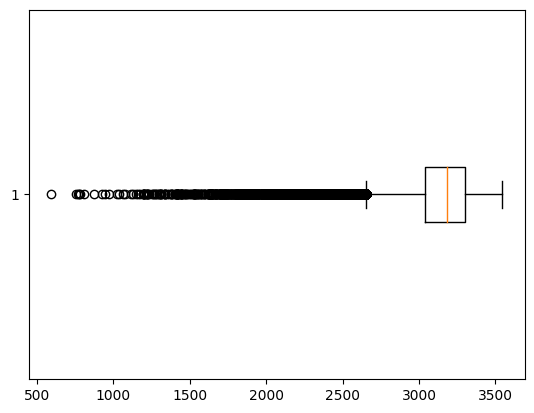

In [13]:
plt.boxplot(user_rating['rating_rank'], vert=False)
plt.show()

selected interquartile range 

Q1=2885.6604892589166, Q3=3075.255572675912


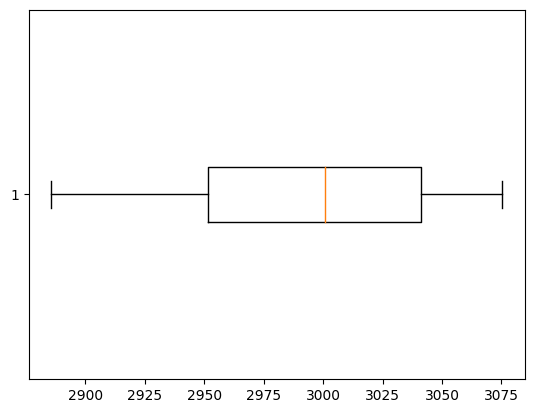

In [14]:
Q1 = user_rating['rating_rank'].quantile(0.1)
Q3 = user_rating['rating_rank'].quantile(0.3)
print(f'Q1={Q1}, Q3={Q3}')
user_rating_iqr = user_rating.loc[(user_rating['rating_rank'] < Q3) & (user_rating['rating_rank'] > Q1)]
user_list = user_rating_iqr['user_id'].tolist()
plt.boxplot(user_rating_iqr['rating_rank'], vert=False)
plt.show()

In [15]:
data_train = data_train.loc[data_train['user_id'].isin(user_list)]
# data_train.drop('rating_rank', axis=1, inplace=True)
data_train = pd.concat([data_train, my_animelist], ignore_index=True)
len(data_train)

10894746

In [16]:
import implicit
from scipy.sparse import csr_matrix

# initialize a model
model = implicit.als.AlternatingLeastSquares(factors=100,
                                        regularization=0.05, 
                                        alpha=2.0,
                                        iterations=20,
                                        random_state=38)

# train the model on a sparse matrix of user/item/confidence weights
user_item_matrix = pd.pivot_table(data_train,
                                  index='user_id', columns='anime_id',
                                  values='rating',
                                  fill_value=0)

# scipy resets indexes
idALS_anime_id = dict((i, j) for i, j in enumerate(user_item_matrix.columns))

user_item_matrix = user_item_matrix.astype(float)
user_item_matrix_csr = csr_matrix(user_item_matrix).tocsr()

model.fit(user_item_matrix_csr)

C:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Python311\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:14<00:00,  3.71s/it]


In [17]:
from implicit.nearest_neighbours import bm25_weight

# weight the matrix, both to reduce impact of users that have played the same artist thousands of times
# and to reduce the weight given to popular items
#user_item_matrix_csr = bm25_weight(user_item_matrix_csr, K1=100, B=0.8)

In [18]:
id_score = model.recommend(-1, user_item_matrix_csr[-1], N=250, filter_already_liked_items=True)
anime_id = [idALS_anime_id[i] for i in id_score[0]]
ALScore = dict((i, j) for i, j in zip(anime_id, id_score[1]))

In [20]:
# my_genres = df_genres[df_genres.index.isin(my_animelist.index)].mean().values

def rec_final(rec):
    name = []
    date = []
    url = []
    als_score = []
    score_mal = []
    # corr = []

    for i in rec:
        if i not in my_animelist.index:
            try:
                name.append(anime.loc[anime['anime_id'] == i]['Name'].values[0])
                date.append(anime.loc[anime['anime_id'] == i]['Aired'].values[0])
                url.append('https://myanimelist.net/anime/' + str(i))
                if type(rec) == list:
                    als_score.append(ALScore[i])
                score_mal.append(anime.loc[anime['anime_id'] == i]['Score'].values[0])
                # corr.append(np.corrcoef(my_genres, df_genres.iloc[int(i)])[0, 1])
            except IndexError:
                pass

    df =  pd.DataFrame({'name': name, 'date': date, 'url': url, 'score mal': score_mal}).\
    sort_values('score mal', ascending=False).drop_duplicates()
    if type(rec) == list:
        df =  pd.DataFrame({'name': name, 'date': date, 'url': url, 'ALS score': als_score, 'score mal': score_mal}).\
        drop_duplicates()
        df['rank'] = df['score mal'].rank() + df['ALS score'].rank()
        df = df.sort_values('rank', ascending=False).drop_duplicates()
    return df

In [21]:
rec_final(anime_id).to_html('rec_final.html', encoding='utf-8', index=False, render_links=True)
rec_final(anime_id)[:10]

,name,date,url,ALS score,score mal,rank
3,Clannad: After Story,"Oct 3, 2008 to Mar 27, 2009",https://myanimelist.net/anime/4181,1.155174,8.96,465.0
2,Sakura-sou no Pet na Kanojo,"Oct 9, 2012 to Mar 26, 2013",https://myanimelist.net/anime/13759,1.160471,8.19,447.5
17,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...,"Apr 15, 2011 to Jun 24, 2011",https://myanimelist.net/anime/9989,0.949840,8.42,441.0
0,Clannad,"Oct 5, 2007 to Mar 28, 2008",https://myanimelist.net/anime/2167,1.199745,8.07,440.0
8,Hyouka,"Apr 23, 2012 to Sep 17, 2012",https://myanimelist.net/anime/12189,1.024064,8.14,438.0
11,Angel Beats!,"Apr 3, 2010 to Jun 26, 2010",https://myanimelist.net/anime/6547,0.997297,8.15,436.0
31,Shigatsu wa Kimi no Uso,"Oct 10, 2014 to Mar 20, 2015",https://myanimelist.net/anime/23273,0.823610,8.74,434.5
25,Ookami to Koushinryou II,"Jul 9, 2009 to Sep 24, 2009",https://myanimelist.net/anime/5341,0.861929,8.36,430.0
9,Kanon (2006),"Oct 6, 2006 to Mar 16, 2007",https://myanimelist.net/anime/1530,1.017818,8.01,424.0
50,One Punch Man,"Oct 5, 2015 to Dec 21, 2015",https://myanimelist.net/anime/30276,0.771187,8.57,411.0


In [22]:
rec_final(popularity_anime['anime_id'][:250]).to_html('popular anime from users dataset.html', encoding='utf-8', index=False, render_links=True)

In [33]:
anime_ranked = anime[['anime_id', 'Score', 'Popularity']].copy()
anime_ranked = anime_ranked.loc[~anime_ranked['Score'].isin(['Unknown'])]
anime_ranked['rank'] = anime_ranked['Score'].rank() + anime_ranked['Popularity'].rank()
rec_final(anime_ranked.sort_values('rank', ascending=False)['anime_id'][:250]).to_html('popular anime by rank.html', encoding='utf-8', index=False, render_links=True)